In [2]:
# 기존 Keras와 TensorFlow 삭제
!pip uninstall -y keras tensorflow

# Keras 2.4.0 및 TensorFlow 2.4.1 설치
!pip install keras==2.8.0 tensorflow==2.8.0-rc0

!pip uninstall protobuf -y
!pip install protobuf==3.19.5

Found existing installation: keras 2.8.0
Uninstalling keras-2.8.0:
  Successfully uninstalled keras-2.8.0
Found existing installation: tensorflow 2.8.0rc0
Uninstalling tensorflow-2.8.0rc0:
  Successfully uninstalled tensorflow-2.8.0rc0
  Using cached keras-2.8.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached tensorflow-2.8.0rc0-cp310-cp310-manylinux2010_x86_64.whl.metadata (2.9 kB)
Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
Using cached tensorflow-2.8.0rc0-cp310-cp310-manylinux2010_x86_64.whl (492.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.8.0rc0 which is incompatible.
Found existing installation: protobuf 3.19.5
Uninstalling protobuf-3.19.5:
  Successfully uninstalled protobuf-3.19.5
  Using cached protobuf-3.19.5-cp310-cp310-manylinux_2_17_x86_64.manylinux

In [3]:
import tensorflow as tf
import numpy as np
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)
print("numpy version:", np.__version__)

TensorFlow version: 2.8.0-rc0
Keras version: 2.8.0
numpy version: 1.26.4


In [4]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [6]:
actions = [
    'come',
    'away',
    'spin',
    'sit',
    'up',
    'bang'
]

data = np.concatenate([
    np.load('dataset/seq_come_1732286469.npy'),
    np.load('dataset/seq_away_1732286469.npy'),
    np.load('dataset/seq_spin_1732286469.npy'),
    np.load('dataset/seq_sit_1732286469.npy'),
    np.load('dataset/seq_up_1732286469.npy'),
    np.load('dataset/seq_bang_1732286469.npy'),
], axis=0)

data.shape

(3029, 30, 100)

In [7]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(3029, 30, 99)
(3029,)


In [8]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(3029, 6)

In [9]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2726, 30, 99) (2726, 6)
(303, 30, 99) (303, 6)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 44,262
Trainable params: 44,262
Non-trainable params: 0
_________________________________________________________________


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
85/86 [============================>.] - ETA: 0s - loss: 8.7000 - acc: 0.4739
Epoch 1: val_acc improved from -inf to 0.49835, saving model to models/model.keras
86/86 [==============================] - 3s 21ms/step - loss: 8.7032 - acc: 0.4743 - val_loss: 10.5724 - val_acc: 0.4983 - lr: 0.0010
Epoch 2/200
85/86 [============================>.] - ETA: 0s - loss: 36.3816 - acc: 0.4471
Epoch 2: val_acc improved from 0.49835 to 0.53465, saving model to models/model.keras
86/86 [==============================] - 2s 18ms/step - loss: 36.3201 - acc: 0.4472 - val_loss: 22.4055 - val_acc: 0.5347 - lr: 0.0010
Epoch 3/200
86/86 [==============================] - ETA: 0s - loss: 39.3086 - acc: 0.4028
Epoch 3: val_acc did not improve from 0.53465
86/86 [==============================] - 1s 17ms/step - loss: 39.3086 - acc: 0.4028 - val_loss: 12.9125 - val_acc: 0.3597 - lr: 0.0010
Epoch 4/200
85/86 [============================>.] - ETA: 0s - loss: 10.9897 - acc: 0.4563
Epoch 4: val_acc d

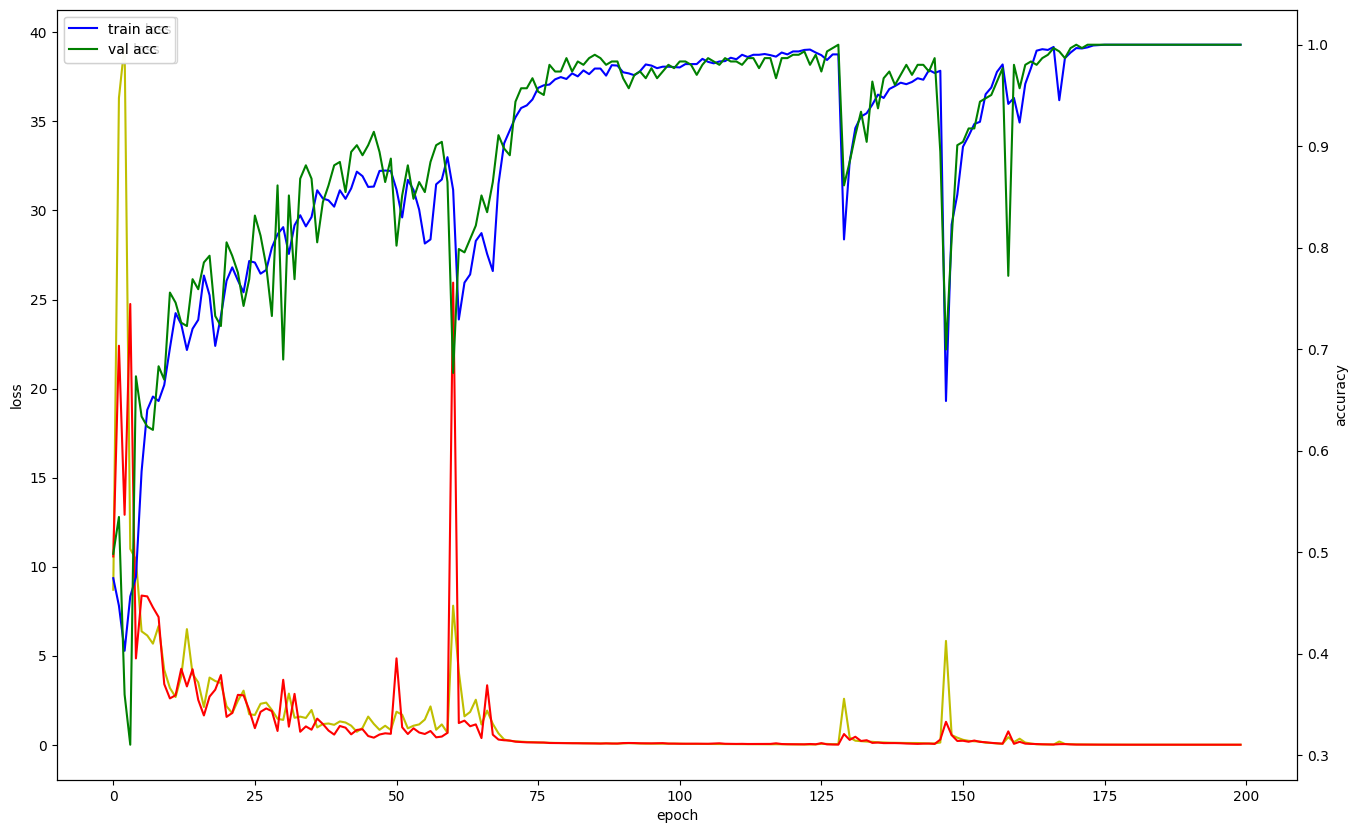

In [12]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [13]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

# H5 형식으로 저장된 모델 불러오기
model = load_model('models/model.keras')

# SavedModel 형식으로 내보내기
model.save("model.h5")

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[244,   0],
        [  0,  59]],

       [[253,   0],
        [  0,  50]],

       [[262,   0],
        [  0,  41]],

       [[254,   0],
        [  0,  49]],

       [[248,   0],
        [  0,  55]],

       [[254,   0],
        [  0,  49]]])